In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from nltk.corpus import gutenberg
from pandas import DataFrame
from shap import Explainer

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import trainer as trainer
from authorship_tool.util.ml.model import (
    LGBMSource,
    Score,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import GutenbergPaths

Project root: /workspaces/shap-authorship-analysis-demo
Path: dump/text_data = /workspaces/shap-authorship-analysis-demo/dump/text_data
Path: data/john_blake_2023/wordLists/adjectivesPastParticiple = /workspaces/shap-authorship-analysis-demo/data/john_blake_2023/wordLists/adjectivesPastParticiple
Path: data/john_blake_2023/wordLists/adjectivesPresentParticiple = /workspaces/shap-authorship-analysis-demo/data/john_blake_2023/wordLists/adjectivesPresentParticiple
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017 = /workspaces/shap-authorship-analysis-demo/data/uoa-thesis-2014-2017
Path: dump/processed_text = /workspaces/shap-authorship-analysis-demo/dump/processed_text
Path: dump/dataset = /workspac

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "bryant"

In [6]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [7]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [8]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

[ The Ball and The Cross by G . K . Chesterton 1909 ]
I . A DISCUSSION SOMEWHAT IN THE AIR
The flying ship of Professor Lucifer sang through the skies like a silver arrow ; the bleak white steel of it , gleaming in the bleak blue emptiness of the evening . That it was far above the earth was no expression for it ; to the two men in it , it seemed to be far above the stars . The professor had himself invented the flying machine , and had also invented nearly everything in it . Every sort of tool or apparatus had , in consequence , to the full , that fantastic and distorted look which belongs to the miracles of science . For the world of science and evolution is far more nameless and elusive and like a dream than the world of poetry and religion ; since in the latter images and ideas remain themselves eternally , while it is the whole idea of evolution that identities melt into each other as they do in a nightmare .
All the tools of Professor Lucifer were the ancient human tools gone mad

In [9]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

[ Stories to Tell to Children by Sara Cone Bryant 1918 ]
TWO LITTLE RIDDLES IN RHYME
There ' s a garden that I ken , Full of little gentlemen ; Little caps of blue they wear , And green ribbons , very fair . ( Flax .)
From house to house he goes , A messenger small and slight , And whether it rains or snows , He sleeps outside in the night . ( The path .)
THE LITTLE YELLOW TULIP
Once there was a little yellow Tulip , and she lived down in a little dark house under the ground . One day she was sitting there , all by herself , and it was very still . Suddenly , she heard a little _tap , tap , tap_ , at the door .
" Who is that ?" she said .
" It ' s the Rain , and I want to come in ," said a soft , sad , little voice .
" No , you can ' t come in ," the little Tulip said .
By and by she heard another little _tap , tap , tap_ on the window - pane .
" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," s

In [10]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 5249 paragraphs (samples)


In [11]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [12]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [13]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]

In [14]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [15]:
datasets: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [16]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)

In [17]:
df = datasets.iloc[:, :-1]
display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,14,14,False,False,False,False,False,0.000000,0.000000,False,False,False,False,False,False,False,False,True,True,False,0.857143,2.857143,0.571429,0.857143,0.571429,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.071429,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.071429,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,8,8,False,False,False,False,False,2.000000,4.000000,True,False,False,False,False,False,False,False,False,True,False,1.000000,3.625000,0.125000,1.000000,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.625000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,164,164,False,False,True,False,False,12.983066,13.250000,False,True,False,False,False,False,False,False,False,False,False,0.573171,4.103659,0.091463,0.530488,0.091463,0.0,0.0,0.0,0.000000,0.000000,0.042683,0.030488,0.018293,0.048780,0.006098,0.128049,0.000000,0.006098,0.176829,0.073171,0.006098,0.000000,0.0,0.000000,0.000000,0.164634,0.018293,0.000000,0.036585,0.000000,0.000000,0.060976,0.000000,0.036585,0.000000,0.000000,0.000000,0.0,0.024390,0.0,0.006098,0.042683,0.018293,0.012195,0.012195,0.024390,0.006098,0.0,0.000000,0.000000,0.0
3,149,149,False,True,True,False,False,4.669642,6.200000,False,False,False,False,True,False,True,False,False,False,False,0.637584,4.389262,0.120805,0.590604,0.120805,0.0,0.0,0.0,0.000000,0.000000,0.067114,0.040268,0.013423,0.013423,0.013423,0.107383,0.000000,0.000000,0.114094,0.053691,0.000000,0.006711,0.0,0.000000,0.006711,0.134228,0.013423,0.000000,0.046980,0.013423,0.000000,0.046980,0.013423,0.060403,0.000000,0.000000,0.000000,0.0,0.020134,0.0,0.020134,0.087248,0.006711,0.067114,0.006711,0.000000,0.026846,0.0,0.000000,0.000000,0.0
4,294,294,True,False,True,False,False,18.699933,22.857143,False,True,False,True,True,False,False,False,True,False,False,0.544218,4.125850,0.136054,0.574830,0.136054,0.0,0.0,0.0,0.003401,0.003401,0.085034,0.027211,0.003401,0.037415,0.010204,0.088435,0.003401,0.000000,0.115646,0.105442,0.000000,0.000000,0.0,0.000000,0.003401,0.122449,0.010204,0.003401,0.034014,0.003401,0.000000,0.064626,0.020408,0.091837,0.000000,0.003401,0.003401,0.0,0.017007,0.0,0.023810,0.068027,0.006803,0.030612,0.003401,0.000000,0.003401,0.0,0.003401,0.000000,0.0
5,91,91,False,True,False,False,False,13.511477,15.250000,True,True,False,False,False,False,True,False,False,False,False,0.758242,4.637363,0.175824,0.593407,0.175824,0.0,0.0,0.0,0.000000,0.000000,0.032967,0.043956,0.000000,0.021978,0.000000,0.076923,0.000000,0.000000,0.131868,0.054945,0.000000,0.000000,0.0,0.000000,0.010989,0.142857,0.054945,0.000000,0.065934,0.000000,0.000000,0.054945,0.021978,0.054945,0.000000,0.000000,0.000000

In [18]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])

array([ True,  True,  True,  True,  True])

In [19]:
print(df.shape)

(5249, 71)


In [20]:
print(df.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [21]:
print(df.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [22]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 3058, number of negative: 878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9865
[LightGBM] [Info] Number of data points in the train set: 3936, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.776931 -> initscore=1.247870
[LightGBM] [Info] Start training from score 1.247870


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [23]:
score: Score | None = result.score

In [24]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.8738668537257341
f1 score: 0.9035971223021583
accuracy score: 0.8469154607768469


In [25]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,170,146
True,55,942


In [26]:
dump(result, GutenbergPaths)

In [27]:
test_data: DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.shap_expected_val
shap_vals = result.shap_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0

In [28]:
shap.initjs()

In [29]:
SHAP_GUTENBERG_FIGURE_DIR: Path = GutenbergPaths.shap_figure_dir

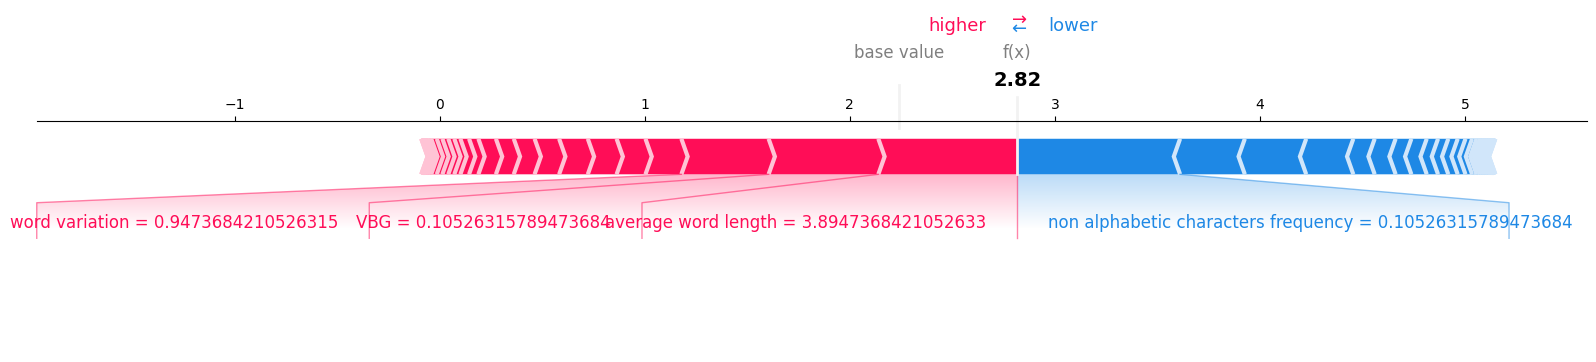

<Figure size 640x480 with 0 Axes>

In [30]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

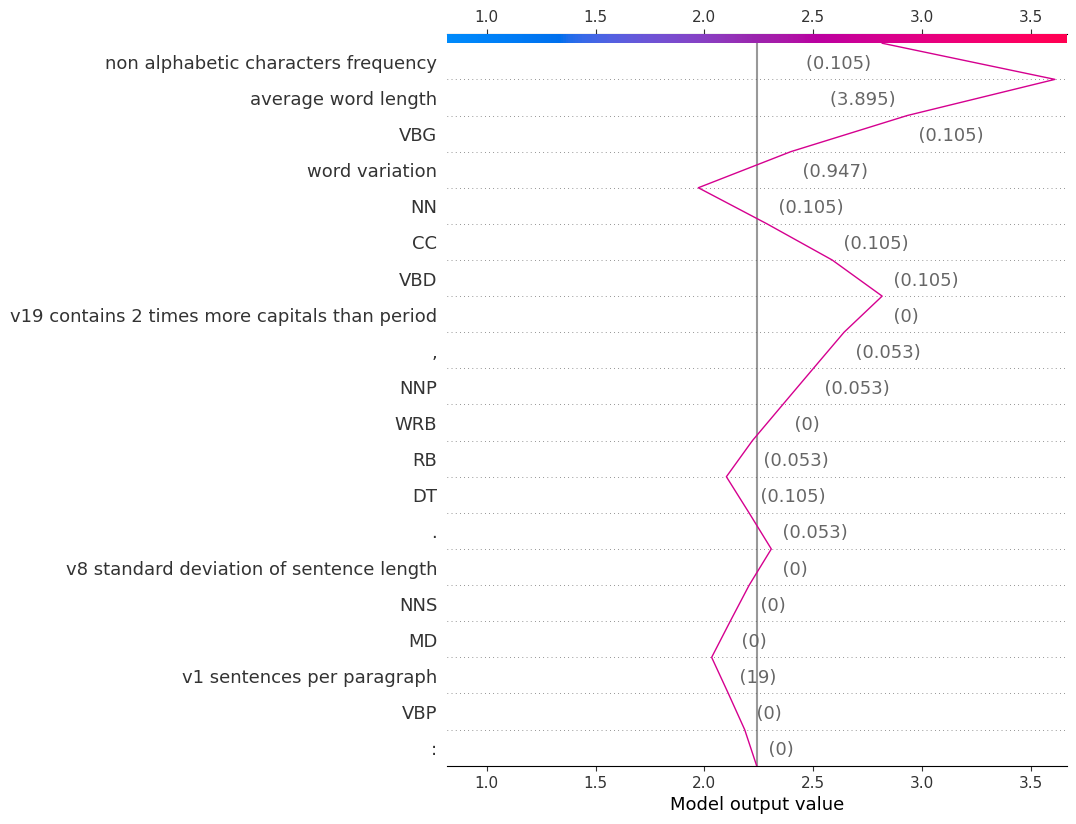

<Figure size 640x480 with 0 Axes>

In [31]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

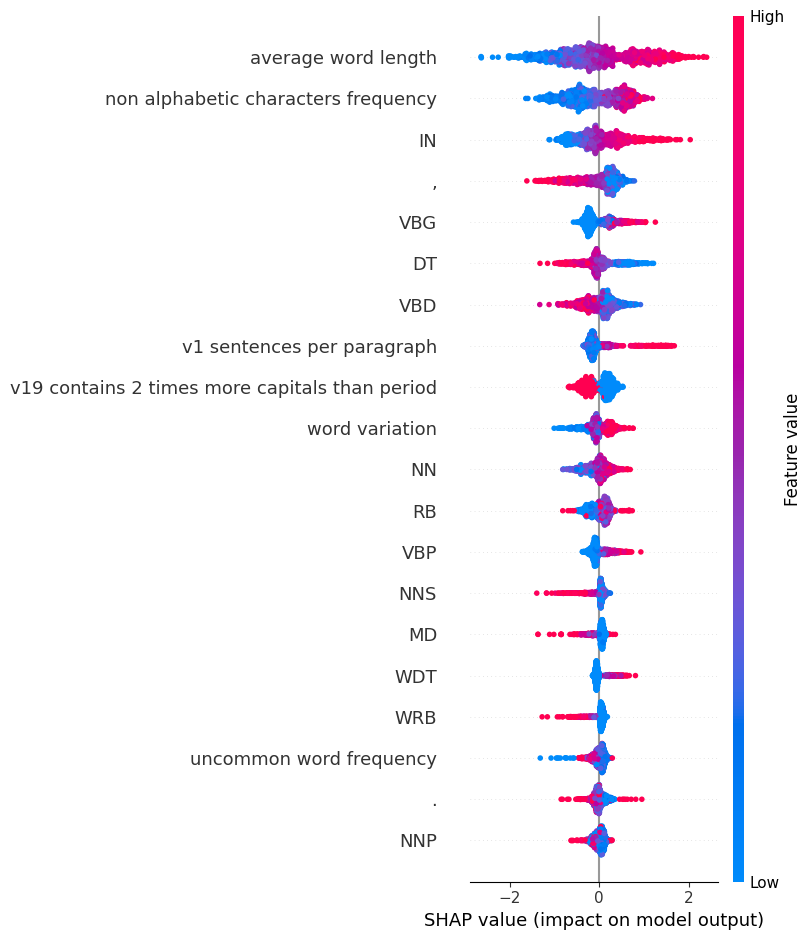

<Figure size 640x480 with 0 Axes>

In [32]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

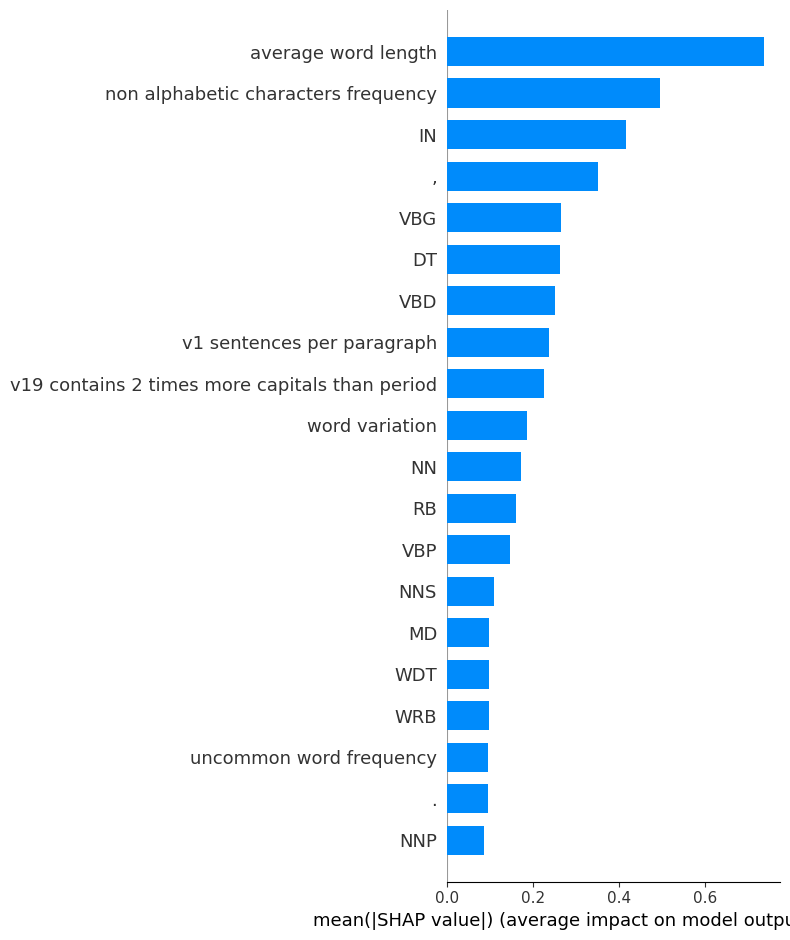

<Figure size 640x480 with 0 Axes>

In [33]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()